# Summary

This challenge & dataset seems to be from an old Kaggle competition. As such, I'm uncertain of the purpose of this exercise since there's plenty of material available on the web which could be replicated i.e. I'm not sure what pure skills can be gleaned from this as Kaggle competitions aren't reflective of real-world scenarios.


# Results

I pulled most of my information from a single source listed below, he claimed to be in the top 5 percentile and a fairly easy to follow approach.

__Feature Engineering:__
- log transformation on the dependent variable (count).
- weekend boolean
- following features: hour, week, day of week, day, month, year, quarter, day of month. 
    
Hour dominated the signal. Pruning of error-based anomalies also helped. Used 250 trees per source listed below but R's implementation of Random Forest is different to that of sklearns so it's best to grid-search this variable.

Decomposing the model into two independent models trained on different y variables(registered, casual) then adding it back together to predict total count to create a "combined model" scored the best, across all folds. There was an "M" shape for the error plot and this approach cured of the dip in the middle folds.

The combined model with anomalies pruned scored slightly better vs non-pruned. As such, I delivered the final model combined with the anomalies pruned.

- median r2 score of 0.88 @ 10 kfolds though this isn't much better than 0.87 (with anomalies)
- mean r2 score was just about the same @ 85


# Next steps

Assuming the goal of this exercise was to maximize model performance given a contrived dataset, I'd do the following if I had more time --  


1. Scour the web for more pre-existing material to review & implement.
1. Either create a proper holdout or use the scoring at Kaggle as one.
1. Grid search model selection specifically XGB (which tops Kaggle competitions), Logistic Regression, ElasticNet.
1. Grid searching model hyper-parameters and other parameters e.g. for the model below:
    - bootstrap
    - min_samples_split
    - node split criterion
    - number of trees
    - max_depth
    - std_deviations of errors to prune anomalies

    Sample grid:
    ```
    random_forest_params={
         'n_estimators': [1, 5, 10, 50, 100, 200, 300], 
         'criterion': ['mse', 'mae'],
         'min_samples_split': [1, 2, 10], 
         'bootstrap': [True, False],
     }
    ```  
1. PCA wrapper function where k-components are grid-searched for optimal r2. This is a regularization technique known as PCR; however, I've found much success with this techique with tree-based models. Logic being, axes can be rotated in such a way leading to less splits from the tree which leads to better stability. This also prunes anomalies as well which will lead to better performance.
1. Binning hour to limit the split search space as given by the decision splits tree.png.
1. Inspection of examples with high errors.
1. One hot encode weather variables.
1. Different transformations on the dependent variable e.g. boxcox.


# Techniques I tried with little to no success 

1. Binning hourly given by the decision tree splits.
1. Basic linear regression.


### sources

__eda, feature engineering:__
- https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/

__helpers functions:__
- https://github.com/asharma567/cool_tools

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from helpers_part2 import *
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%pylab inline

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.shape, df_test.shape

((10886, 12), (6493, 9))

In [4]:
df_train.datetime.max(), df_train.datetime.min()

('2012-12-19 23:00:00', '2011-01-01 00:00:00')

In [5]:
df_test.datetime.max(), df_test.datetime.min()

('2012-12-31 23:00:00', '2011-01-20 00:00:00')

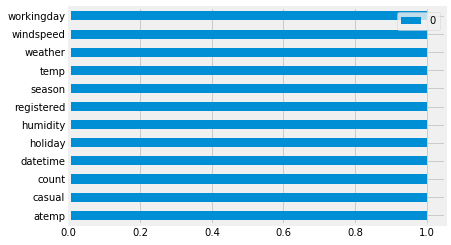

In [6]:
missing_values_finder(df_train).plot(kind='barh')

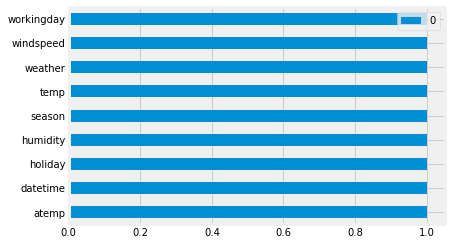

In [7]:
missing_values_finder(df_test).plot(kind='barh')

In [8]:
X = df_train[df_test.columns]

preprocessor(X)

X = X.drop(['datetime'], axis=1)

df_train['count_log'] = df_train['count'].apply(lambda x: np.log(x + 1) )
y = df_train['count_log']

params = {'n_jobs':-1, 'random_state':0, 'n_estimators':250}
rf = RandomForestRegressor(**params)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

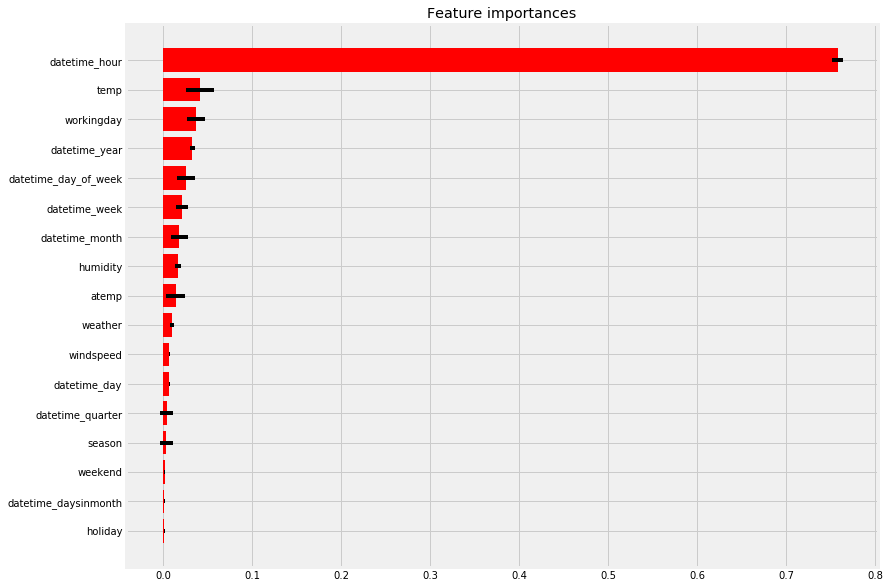

In [9]:
feature_importance_plot(X.columns, rf)

In [10]:
median_score1, mean_score1, scores_model1 = get_model_cv_scores(
    rf, 
    X, 
    y,
    scoring='r2', 
    folds=10
)


In [11]:
anomalies_idx_pruned, errors, anomalies_idx = get_errors(rf, X, y, 1)
len(anomalies_idx)

2134

In [12]:
median_score2, mean_score2, scores_model2 = get_model_cv_scores(
    rf, 
    X.ix[anomalies_idx_pruned], 
    y.ix[anomalies_idx_pruned], 
    scoring='r2', 
    folds=10
)


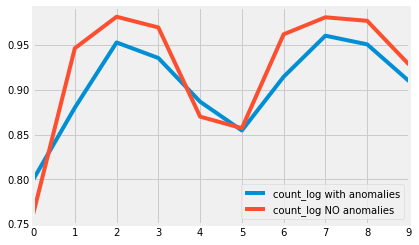

In [13]:
pd.Series(scores_model1).plot(label='count_log with anomalies')
pd.Series(scores_model2).plot(label='count_log NO anomalies')
plt.legend()

In [14]:
median_score2, median_score1, mean_score2, mean_score1

(0.95418131402004125,
 0.91214031412505658,
 0.92338450381974246,
 0.90445351861795265)

In [15]:
df_train['registered_log'] = df_train['registered'].apply(lambda x: np.log(x + 1) )
y = df_train['registered_log']

rf_registered = RandomForestRegressor(**params)
rf_registered.fit(    
    X.ix[anomalies_idx_pruned], 
    y.ix[anomalies_idx_pruned]
)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

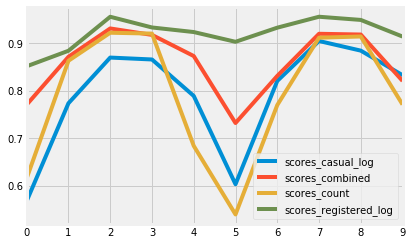

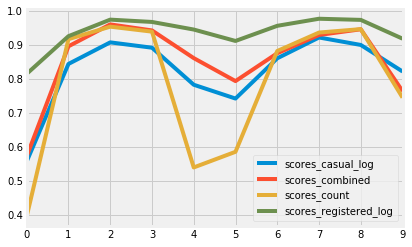

In [16]:
df_train['casual_log'] = df_train['casual'].apply(lambda x: np.log(x + 1) )
df_train['registered_log'] = df_train['registered'].apply(lambda x: np.log(x + 1) )

input_df = df_train.ix[anomalies_idx_pruned].reset_index()
del input_df['index']
no_anomalies_scores = get_all_cv_scores(input_df, df_test, params)

scores = get_all_cv_scores(df_train, df_test, params)
names = 'scores_count,scores_casual_log,scores_registered_log,scores_combined'.split(',')


pd.DataFrame(dict(zip(names, scores))).plot()
pd.DataFrame(dict(zip(names, no_anomalies_scores))).plot()

(0.85884382466633313,
 0.85449758226542305,
 0.87249892377837845,
 0.88611930867645783)

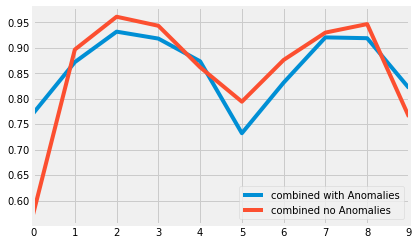

In [17]:
pd.Series(scores[-1]).plot(label='combined with Anomalies')
pd.Series(no_anomalies_scores[-1]).plot(label='combined no Anomalies')
plt.legend()
np.mean(scores[-1]), np.mean(no_anomalies_scores[-1]), np.median(scores[-1]), np.median(no_anomalies_scores[-1])

In [18]:

y = df_train['casual_log']

rf_casual = RandomForestRegressor(**params)
rf_casual.fit(    
    X.ix[anomalies_idx_pruned], 
    y.ix[anomalies_idx_pruned]
)

y = df_train['registered_log']

rf_registered = RandomForestRegressor(**params)
rf_registered.fit(    
    X.ix[anomalies_idx_pruned], 
    y.ix[anomalies_idx_pruned]
)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [19]:
class Model_Combined(object):

    def __init__(self, model1, model2, **kwargs):
        self.m1 = model1
        self.m2 = model2

    def predict(self, data_point):
        return (np.exp(self.m1.predict(data_point)) - 1) + \
                (np.exp(self.m2.predict(data_point)) - 1)

        
    
model = Model_Combined(rf_registered, rf_casual)    

In [26]:
#sanity check
X_test = df_train[df_test.columns]
preprocessor(X_test)
X_test = X_test.drop(['datetime'],axis=1)

#          16.0
#          40.0
#          32.0
#          13.0
#           1.0
#           1.0

np.exp(rf_casual.predict(X_test[:4])) - 1, np.exp(rf_registered.predict(X_test[:4]))- 1, model.predict(X_test[:4])

(array([ 4.49111594,  4.07946918,  3.51656272,  2.6995019 ]),
 array([ 30.21493962,  25.06992041,  27.92934103,  11.13216063]),
 array([ 34.70605556,  29.14938959,  31.44590375,  13.83166253]))

In [27]:
X_test = df_test[:]
preprocessor(X_test)
X_test = X_test.drop(['datetime'],axis=1)

final_preds = list(map(np.round,model.predict(X_test)))
final_preds

[35.0,
 29.0,
 31.0,
 14.0,
 5.0,
 5.0,
 6.0,
 17.0,
 45.0,
 62.0,
 48.0,
 58.0,
 80.0,
 107.0,
 114.0,
 105.0,
 90.0,
 108.0,
 41.0,
 41.0,
 40.0,
 40.0,
 46.0,
 46.0,
 41.0,
 27.0,
 32.0,
 23.0,
 5.0,
 16.0,
 31.0,
 53.0,
 71.0,
 55.0,
 69.0,
 86.0,
 79.0,
 61.0,
 65.0,
 72.0,
 68.0,
 76.0,
 39.0,
 51.0,
 34.0,
 28.0,
 29.0,
 12.0,
 2.0,
 2.0,
 3.0,
 32.0,
 70.0,
 168.0,
 93.0,
 45.0,
 48.0,
 62.0,
 62.0,
 74.0,
 71.0,
 79.0,
 165.0,
 160.0,
 107.0,
 57.0,
 42.0,
 27.0,
 14.0,
 11.0,
 3.0,
 2.0,
 2.0,
 4.0,
 34.0,
 74.0,
 181.0,
 105.0,
 40.0,
 56.0,
 69.0,
 62.0,
 64.0,
 66.0,
 87.0,
 206.0,
 180.0,
 112.0,
 58.0,
 48.0,
 36.0,
 17.0,
 10.0,
 5.0,
 2.0,
 2.0,
 5.0,
 34.0,
 84.0,
 194.0,
 114.0,
 56.0,
 60.0,
 75.0,
 70.0,
 63.0,
 63.0,
 87.0,
 181.0,
 167.0,
 122.0,
 59.0,
 44.0,
 39.0,
 20.0,
 11.0,
 4.0,
 2.0,
 2.0,
 5.0,
 33.0,
 91.0,
 206.0,
 120.0,
 48.0,
 58.0,
 78.0,
 69.0,
 69.0,
 66.0,
 83.0,
 171.0,
 161.0,
 108.0,
 64.0,
 46.0,
 38.0,
 21.0,
 11.0,
 5.0,
 2.0,
 2.0,
 5.0,